# Imports

In [6]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

# Initialize MLFLOW

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/Jupyter Notebook/mlruns/1', creation_time=1731909863648, experiment_id='1', last_update_time=1731909863648, lifecycle_stage='active', name='nyc-taxi', tags={}>

# Model Train

In [8]:
df = pd.read_parquet('../data/green_tripdata_2024-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

np.float64(7.1228220948023795)

/tmp/ipykernel_3869/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3869/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


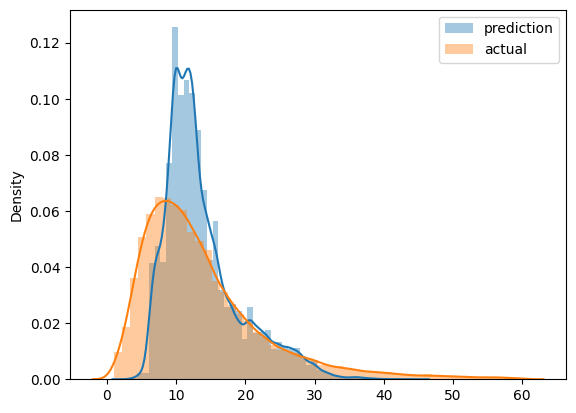

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('../data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2024-02.parquet')

In [13]:
len(df_train), len(df_val)

(54373, 51497)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(5.9947992164797)

In [18]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# Custom Run

In [34]:
with mlflow.start_run(run_name="custom run"):
    mlflow.set_tag("developer","aaghash")

    mlflow.log_param("train-data-path",'../data/green_tripdata_2024-01.parquet')
    mlflow.log_param("val-data-path",'../data/green_tripdata_2024-02.parquet')

    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

# HyperOpt for Hyper Parameter Tuning

In [35]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [38]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=5,
    trials=Trials()
)

  0%|                            | 0/5 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:41:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.87301                                            
[1]	validation-rmse:7.00420                                            
[2]	validation-rmse:6.40285                                            
[3]	validation-rmse:6.00424                                            
[4]	validation-rmse:5.73579                                            
[5]	validation-rmse:5.56096                                            
[6]	validation-rmse:5.44949                                            
[7]	validation-rmse:5.37417                                            
[8]	validation-rmse:5.31842                                            
[9]	validation-rmse:5.28288                                            
[10]	validation-rmse:5.25745                                           
[11]	validation-rmse:5.23723                                           
[12]	validation-rmse:5.22125                                           
[13]	validation-rmse:5.21086                                    

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:42:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.84385                                            
[1]	validation-rmse:5.45233                                            
[2]	validation-rmse:5.38315                                            
[3]	validation-rmse:5.36154                                            
[4]	validation-rmse:5.34420                                            
[5]	validation-rmse:5.32269                                            
[6]	validation-rmse:5.31833                                            
[7]	validation-rmse:5.31612                                            
[8]	validation-rmse:5.31326                                            
[9]	validation-rmse:5.31163                                            
[10]	validation-rmse:5.30972                                           
[11]	validation-rmse:5.30293                                           
[12]	validation-rmse:5.30008                                           
[13]	validation-rmse:5.29979                                    

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:42:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.78728                                            
[1]	validation-rmse:5.32451                                            
[2]	validation-rmse:5.24142                                            
[3]	validation-rmse:5.22679                                            
[4]	validation-rmse:5.22332                                            
[5]	validation-rmse:5.22262                                            
[6]	validation-rmse:5.22275                                            
[7]	validation-rmse:5.21890                                            
[8]	validation-rmse:5.21978                                            
[9]	validation-rmse:5.21832                                            
[10]	validation-rmse:5.21218                                           
[11]	validation-rmse:5.21408                                           
[12]	validation-rmse:5.21399                                           
[13]	validation-rmse:5.21436                                    

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:42:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04622                                            
[1]	validation-rmse:7.25806                                            
[2]	validation-rmse:6.68458                                            
[3]	validation-rmse:6.27380                                            
[4]	validation-rmse:5.98375                                            
[5]	validation-rmse:5.78180                                            
[6]	validation-rmse:5.63460                                            
[7]	validation-rmse:5.53493                                            
[8]	validation-rmse:5.46395                                            
[9]	validation-rmse:5.41283                                            
[10]	validation-rmse:5.37495                                           
[11]	validation-rmse:5.34226                                           
[12]	validation-rmse:5.32321                                           
[13]	validation-rmse:5.30617                                    

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:43:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10380                                            
[1]	validation-rmse:6.15196                                            
[2]	validation-rmse:5.68776                                            
[3]	validation-rmse:5.46303                                            
[4]	validation-rmse:5.38357                                            
[5]	validation-rmse:5.34795                                            
[6]	validation-rmse:5.32484                                            
[7]	validation-rmse:5.31252                                            
[8]	validation-rmse:5.30428                                            
[9]	validation-rmse:5.29989                                            
[10]	validation-rmse:5.29719                                           
[11]	validation-rmse:5.28753                                           
[12]	validation-rmse:5.28075                                           
[13]	validation-rmse:5.27911                                    

# AutoLog With MLFLOW

## For same data As Above

In [39]:
mlflow.xgboost.autolog()

params = {
    "learning_rate": 0.16771722489845498,
    "max_depth": 14,
    "min_child_weight": 2.4093059164340387,
    "objective": "reg:linear",
    "reg_alpha": 0.16130114012350805,
    "reg_lambda": 0.002544204427477435,
    "seed": 42
}
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/11/23 18:56:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fd53150a54b5401fa4ed3ef2bb258732', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.16626


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:56:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:7.44225
[2]	validation-rmse:6.89122
[3]	validation-rmse:6.48178
[4]	validation-rmse:6.17699
[5]	validation-rmse:5.95047
[6]	validation-rmse:5.78405
[7]	validation-rmse:5.66600
[8]	validation-rmse:5.57777
[9]	validation-rmse:5.51253
[10]	validation-rmse:5.46746
[11]	validation-rmse:5.42922
[12]	validation-rmse:5.40291
[13]	validation-rmse:5.38010
[14]	validation-rmse:5.36375
[15]	validation-rmse:5.34785
[16]	validation-rmse:5.33820
[17]	validation-rmse:5.32607
[18]	validation-rmse:5.31917
[19]	validation-rmse:5.31416
[20]	validation-rmse:5.30907
[21]	validation-rmse:5.30472
[22]	validation-rmse:5.30198
[23]	validation-rmse:5.30009
[24]	validation-rmse:5.29545
[25]	validation-rmse:5.29363
[26]	validation-rmse:5.29250
[27]	validation-rmse:5.29129
[28]	validation-rmse:5.28927
[29]	validation-rmse:5.28701
[30]	validation-rmse:5.28562
[31]	validation-rmse:5.28403
[32]	validation-rmse:5.28299
[33]	validation-rmse:5.28210
[34]	validation-rmse:5.28082
[35]	validation-rmse:5.

2024/11/23 18:57:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/11/23 18:57:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:57:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/11/23 18:57:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# For Multiple Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "../data/green_tripdata_2024-01.csv")
        mlflow.log_param("valid-data-path", "../data/green_tripdata_2024-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        